# Defining federated baseline

In [ ]:
#-- CLONNING FedML PROJECT AND EXTRACTING PACKAGES
!git clone https://github.com/shaoxiongji/federated-learning.git
!mv federated-learning/models models/
!mv federated-learning/utils utils/
!rm -rf federated-learning

Cloning into 'federated-learning'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 36.72 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
# %%
#-- LIBRARIES
import ast
import random
import copy
from datetime import datetime

import numpy as np

import pandas as pd

import torch
from torch.optim import SGD
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.models import resnet50
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip

import matplotlib.pyplot as plt

import numpy as np

from google.colab import files

from models.Fed import FedAvg
from models.Update import LocalUpdate

In [ ]:
#-- DEFINING HELPER CLASS
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
#-- SELECTING THE PROCESSOR
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

In [ ]:
#-- CREATING THE DATAFRAME TO REGISTER STATS
stats_file = 'progress-niid-GN.csv'
stats = pd.DataFrame(columns=['epoch', 'devices', 'loss', 'accuracy'])
try:
    stats = pd.read_csv(stats_file)
except:
    pass

In [ ]:
#-- DEFINING METHODS TO MODIFY STATS AND DIST FILES
def register_progress(epoch, batch=None, loss=None, accuracy=None):
    idx = len(stats)
    stats.loc[idx] = [epoch, batch, loss, accuracy]

def save_progress():
    stats.to_csv(stats_file, header=True, index=False)

## Defining Methods

In [ ]:
#-- DEFINE METHOD TO SET GROUP NORMALIZATION
def bn_to_gn(layer, num_groups):
    for name, _ in layer.named_modules():
        if name:
            try:
                sub_layer = getattr(layer, name)
                if isinstance(sub_layer, nn.BatchNorm2d):
                    num_channels = sub_layer.num_features
                    layer._modules[name] = nn.GroupNorm(num_groups, num_channels)
            except AttributeError:
                name = name.split('.')[0]
                sub_layer = getattr(layer, name)
                sub_layer = bn_to_gn(sub_layer, num_groups)
                layer.__setattr__(name=name, value=sub_layer)
    return layer

In [ ]:
#-- DEFINING IID GENERATOR (based on FedML)
def get_iid_dict(dataset, num_users):
    idxs_lbl = []
    for i in range(len(dataset)):
        idxs_lbl.append(dataset[i][1])
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    labels_dist = np.zeros((num_users, 10), dtype=int)
    for i in range(num_users):
        selected = set(np.random.choice(all_idxs, num_items, replace=False))
        dict_users[i] = selected
        for idx in selected:
            labels_dist[i][idxs_lbl[idx]] += 1
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users, labels_dist

In [ ]:
#-- DEFINING NON-IID GENERATOR
def get_non_iid_dict(dataset, num_users):
    all_idxs = [i for i in range(len(dataset))]
    idxs_lbl = [[] for i in range(10)]
    for i in range(len(dataset)):
        idxs_lbl[dataset[i][1]].append(i)

    dict_users = {i:set() for i in range(num_users)}
    labels_dist = np.zeros((num_users, 10), dtype=int)
    labels_prob = [[] for i in range(num_users)]
    for i in range(num_users):
      labels_prob[i] = np.random.dirichlet(tuple([np.random.randint(1,2) for m in range(10)]))
    while len(all_idxs) > 0:
        user = np.random.randint(num_users)
        clazz = np.random.randint(10)
        size = int(labels_prob[user][clazz]*50)
        if size > len(idxs_lbl[clazz]):
          size = len(idxs_lbl[clazz])
        selected = list(np.random.choice(idxs_lbl[clazz], size, replace=False))
        dict_users[user].update(selected)
        labels_dist[user][clazz] += len(selected)
        idxs_lbl[clazz] = list(set(idxs_lbl[clazz]) - dict_users[user])
        all_idxs = list(set(all_idxs) - dict_users[user])
    return dict_users, labels_dist

In [ ]:
#-- DEFINING TRAINING LOOP (based on FedML)
def train(dataset, model, data_dist, frac_users, num_users, epoch, args):
    loss_locals = []
    w_locals = []
    m = max(int(frac_users * num_users), 1)
    idxs_users = np.sort(np.random.choice(range(num_users), m, replace=False))
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset, idxs=data_usr_dist[idx])
        local_model = copy.deepcopy(model)
        w, loss = local.train(net=local_model.to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        loss_avg = sum(loss_locals) / len(loss_locals)
        if idx%20 == 0:
              register_progress(epoch, idx, loss_avg)
        del local, local_model, loss, loss_avg
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    model.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('--Average loss {:.3f}'.format(loss_avg))
    return loss_avg

In [ ]:
#-- DEFINING TEST LOOP
def test(dataloader, model, epoch):
    model.to(torch.device(device))
    model.eval()
    size = 0
    correct = 0
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(torch.device(device))
            y = y.to(torch.device(device))
            outs = model(X)
            _, pred = torch.max(outs.data, 1)
            size += y.size(0)
            correct += (pred == y).sum().item()
    correct /= size
    register_progress(epoch, accuracy=correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%\n")

## Training the NN on CIFAR10

In [ ]:
#-- LOADING DATASET
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([
            RandomHorizontalFlip(),
            RandomCrop(32, 4),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
        ])
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
        ])
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
            'ship', 'truck')

batch = 128
test_dataloader = DataLoader(test_data, batch_size=batch, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
#-- LOADING DATA DISTRIBUTION ACROSS DEVICES
#data_usr_dist, labels_dist = get_iid_dict(training_data, 100)
data_usr_dist, labels_dist = get_non_iid_dict(training_data, 100)

In [ ]:
#-- REMOVING BATCH WITH SIZE 1
for i in range(len(labels_dist)):
    if np.sum(labels_dist[i], axis=0) < 2:
        data_usr_dist[i] = data_usr_dist[i].remove(max(data_usr_dist[i]))
print(data_usr_dist)

{0: {30725, 43014, 49159, 20492, 49165, 6162, 24594, 32800, 47138, 28707, 10282, 38956, 28717, 12338, 47155, 6198, 24634, 74, 16463, 12368, 34895, 49235, 49240, 34905, 18522, 43101, 4197, 12395, 41068, 47215, 12400, 32885, 28793, 20602, 41083, 14466, 8322, 36996, 41093, 14472, 10385, 12441, 47259, 14492, 41121, 6306, 8384, 4294, 24776, 39125, 14566, 24810, 35068, 41214, 14594, 16648, 41224, 49420, 39182, 26898, 41240, 10534, 24874, 12589, 14640, 37171, 37178, 31041, 22851, 18756, 8525, 31054, 24919, 4439, 49497, 35172, 29030, 22886, 29034, 4466, 20858, 47491, 6532, 10638, 43409, 18834, 37265, 2452, 20889, 35228, 2461, 43422, 10663, 18863, 37297, 47541, 10688, 16837, 39366, 8645, 12747, 37324, 22990, 43471, 12750, 37330, 33236, 18901, 14804, 39384, 2523, 43487, 39393, 43489, 35300, 8680, 4588, 41458, 27124, 43516, 33279, 39433, 49685, 35352, 14883, 12836, 39461, 548, 47664, 45618, 566, 21048, 49726, 21058, 37442, 8775, 6732, 25167, 23120, 35418, 6747, 12891, 2665, 35437, 49773, 4725, 10

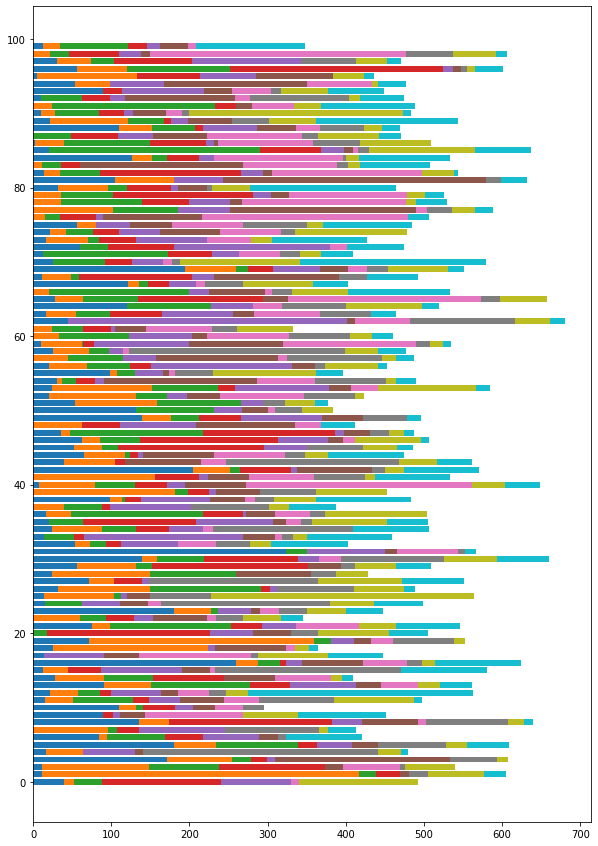

In [ ]:
#-- PLOTTING DATA DISTRIBUTION
samples = len(labels_dist)
labels_dist = labels_dist.T
plt.figure(figsize=(10,15))
for i in range(10):
    if i==0:
        plt.barh(range(samples), labels_dist[i])
    else:
        plt.barh(range(samples), labels_dist[i], left=np.sum(np.array([labels_dist[j] for j in range(0, i)]), axis=0))
plt.show()


In [ ]:
#-- DEFINING HYPERPARAMS AND MODEL
local_learning_rate = 1
local_epochs = 10
local_batch = 128
frac_users = 0.2
num_users = 50

epochs = 20
momentum = 0.2
model = resnet50(num_classes=10)
#bn_to_gn(model, 2) #Comment this to use BN
params = dotdict({
      'device': torch.device(device), 
      'local_bs':local_batch,
      'lr': local_learning_rate,
      'local_ep':local_epochs,
      'momentum': momentum
    })

In [ ]:
#-- LOADING THE NET IF EXISTS
model_file = 'fed-resnet50-niid-BN545'
try:
    model.load_state_dict(torch.load(model_file))
except:
    pass

Epoch 2
-------
--Average loss 23.107
Test Error: 
 Accuracy: 10.0%

Epoch 3
-------
--Average loss 6.945
Test Error: 
 Accuracy: 10.0%

Epoch 4
-------
--Average loss 2.396
Test Error: 
 Accuracy: 10.0%

Epoch 5
-------
--Average loss 2.085
Test Error: 
 Accuracy: 10.0%

Epoch 6
-------
--Average loss 2.050
Test Error: 
 Accuracy: 12.6%

Epoch 7
-------
--Average loss 1.904
Test Error: 
 Accuracy: 15.9%

Epoch 8
-------
--Average loss 1.639
Test Error: 
 Accuracy: 11.3%

Epoch 9
-------
--Average loss 1.661
Test Error: 
 Accuracy: 16.4%

Epoch 10
-------
--Average loss 1.557
Test Error: 
 Accuracy: 17.2%

Epoch 11
-------
--Average loss 1.567
Test Error: 
 Accuracy: 13.6%

Epoch 12
-------
--Average loss 1.552
Test Error: 
 Accuracy: 22.6%

Epoch 13
-------
--Average loss 1.665
Test Error: 
 Accuracy: 15.5%

Epoch 14
-------
--Average loss 1.499
Test Error: 
 Accuracy: 19.6%

Epoch 15
-------
--Average loss 1.321
Test Error: 
 Accuracy: 25.3%

Epoch 16
-------
--Average loss 1.346
Tes

Text(0, 0.5, 'train_loss')

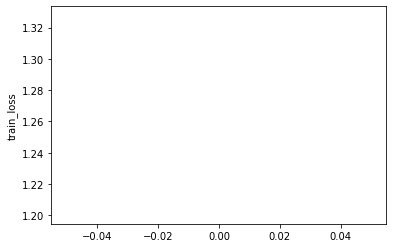

In [ ]:
#-- TRAINING THE NET
last_epoch = np.nan_to_num(stats['epoch'].max())
last_epoch = int(last_epoch) + 1
for epoch in range(last_epoch, epochs + last_epoch):
    loss_train = []
    print(f"Epoch {epoch+1}\n-------")
    loss_avg = train(training_data, model, data_usr_dist, frac_users, num_users, epoch, params)
    test(test_dataloader, model, epoch)
    loss_train.append(loss_avg)

plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')


In [ ]:
#-- SAVING THE MODEL AND STATS
torch.save(model.state_dict(), model_file)
save_progress()
files.download(model_file)
files.download(stats_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


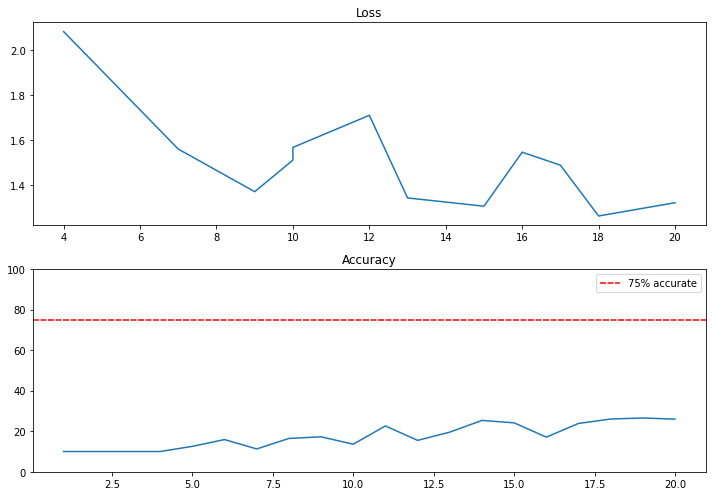

In [ ]:
df_loss = stats.drop('accuracy', 1)
df_loss = df_loss.dropna()

df_acc = stats.drop(['loss', 'devices'], 1)
df_acc = df_acc.dropna()

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(10,7)
axs[0].set_title('Loss')
axs[0].plot(df_loss['epoch'], df_loss['loss'])

axs[1].set_title('Accuracy')
axs[1].set_ylim((0,100))
axs[1].axhline(75, dashes=(4,1), color='red', label='75% accurate')
axs[1].plot(df_acc['epoch'], df_acc['accuracy'] * 100)
axs[1].legend()
fig.tight_layout()